# Assignment 4. Deep Learning

*Foundations of Data Science*  
*Dr. Khalaj (Fall 2023)*  

*For questions 2-4 refer to @alregamo on Telegram.*

### Description  
This homework consists of four questions, each aimed at one category in the world of Deep Learning.   
1. Getting familiarized with sentiment analysis (A subject also covered in the course project).
   
2. Multi-layer perceptron (MLP). 
   
3. Convolutional Neural Networks (CNN).
   
4. Variational Autoencoders (VAE).

### Information  
Complete the information box below.

In [223]:
full_name = 'Ali Nikkhah'
student_id = '99102445'

### Note
The questions are not necessarily in order of difficulty. You are obligated to answer **3 out of 4** questions. The fourth question is optional and is considered as bonus.

## 2 Multi-layer Perceptron (MLP)

**In this assignment you'll be working with Dorothea Dataset.**

DOROTHEA is a drug discovery dataset. Chemical compounds represented by structural molecular features must be classified as active (binding to thrombin) or inactive. To find out more about dataset, refer to this link: https://archive.ics.uci.edu/ml/datasets/Dorothea

You should implement a classifier with Neural Networks and for this purpose we will be using PyTorch as framework.

### 2.1 Importing libraries, modules and Dataset.

In this part, import all the libraries and modules needed to solve the problem.

In [161]:
import os
import random 
import torch 
import torch.nn as nn
import numpy as np
from sklearn.decomposition import PCA as sklearnPCA
from sklearn.naive_bayes import BernoulliNB

In [162]:
import requests
import zipfile
import io

# URL of the dataset zip file
url = 'https://archive.ics.uci.edu/static/public/169/dorothea.zip'

# Send a GET request to download the file
response = requests.get(url)

# Check if the request was successful (status code 200)
if response.status_code == 200:
    # Read the content of the zip file
    zip_content = io.BytesIO(response.content)
    
    # Extract the contents of the zip file
    with zipfile.ZipFile(zip_content, 'r') as zip_ref:
        zip_ref.extractall('dorothea')  # Replace 'path_to_extract' with the desired extraction path
    print("Dataset extracted successfully!")
else:
    print("Failed to download the dataset.")


Dataset extracted successfully!


In [168]:
from tqdm import tqdm
import pandas as pd
import numpy as np

def loadData(trainingFile, testingFile):

    def convertDataframe(inputFile):
        data = pd.DataFrame(columns=range(100000))

        for i in tqdm(range(len(inputFile)), desc="Converting to DataFrame"):
            record = np.fromstring(inputFile[i], dtype=int, sep=' ')
            record_bool = [0 for j in range(100000)]
            for col in record:
                record_bool[col - 1] = 1

            data.loc[i] = record_bool

        return data

    with open(trainingFile, "r") as fr1:
        trainFile = fr1.readlines()

    # Split each line in the two files into label and data
    train_data_list = []
    train_labels_list = []

    for inputData in trainFile:
        train_labels_list.append(inputData[0])

        # Remove the activity label (0/1) and new line character from each record
        inputData = inputData.replace("0\t", "")
        inputData = inputData.replace("1\t", "")
        inputData = inputData.replace("\n", "")
        train_data_list.append(inputData)

    train_labels = np.asarray(train_labels_list)
    train_data = convertDataframe(train_data_list)

    with open(testingFile, "r") as fr2:
        testFile = fr2.readlines()

    test_data = convertDataframe(testFile)

    return train_data, test_data


In [169]:
#Read the training and the test data set and get 3 separate dataframes of training reviews, test reviews and training labels
train_data, test_data = loadData('dorothea_train.data', 'dorothea_valid.data')

Converting to DataFrame: 100%|████████████████| 350/350 [00:22<00:00, 15.81it/s]


### 2.2 Normalize and 2.3 Dimensionality Reduction
You can normalize your data using <code>Scikit-Learn</code> modules here.

There are too many attributes for each instance of dataset. We will suffer from sparse data and long training phase. Thus you can reduce dimensions to get better accuracy. 

Principal component analysis (PCA) is the process of computing the principal components and using them to perform a change of basis on the data.

Apply PCA on Dorothea dataSet using <code>Scikit-Learn</code>.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from tqdm import tqdm

In [113]:
def findOptimalPCA(train_data):
    variance_info = []
    k = 100
    pca = PCA(n_components=k)
    pca.fit(train_data)
    total_var = sum(pca.explained_variance_ratio_)
    variance_info.append(total_var)
    while total_var < 0.9:
        print('finding PCA for k=',k)
        if(k<700):
            k += 100
            pca = PCA(n_components=k)
            pca.fit(train_data)
            total_var = sum(pca.explained_variance_ratio_)
            variance_info.append(total_var)
        else:
            break;
    return variance_info
def plotVarianceInfo(variance_info):
    k_values = range(100, len(variance_info) * 100 + 100, 100)
    plt.figure(figsize=(10, 6))
    plt.plot(k_values, variance_info, marker='o', linestyle='-', color='r')
    plt.xlabel('Number of Components (k)')
    plt.ylabel('Variance Information Stored')
    plt.title('Variance Information vs Number of Components')
    plt.grid(True)
    plt.show()

finding PCA for k= 100
finding PCA for k= 200
finding PCA for k= 300
finding PCA for k= 400
finding PCA for k= 500
finding PCA for k= 600


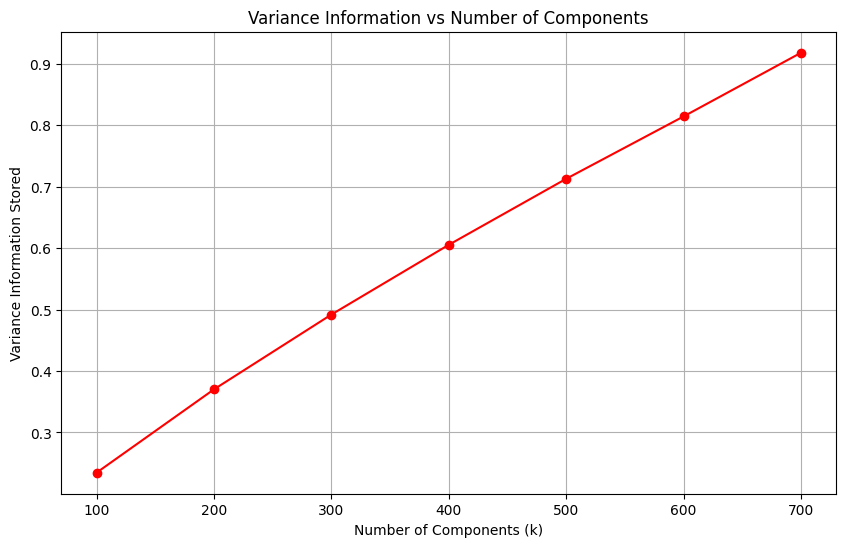

In [114]:
variance_info = findOptimalPCA(train_data)
plotVarianceInfo(variance_info)

## as a result of representation plot above, we choose `k=600' for keeping a suitable variance information fraction of the whole data features

In [176]:
from sklearn.decomposition import PCA
pca = PCA(n_components=600)
# Fit PCA on the training data
pca.fit(train_data)
# Transform both training and test data using the fitted PCA
PCA_projected_trainData = pca.transform(train_data)
PCA_projected_testData = pca.transform(test_data)


In [181]:
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler

normalized_train_data = scaler.fit_transform(PCA_projected_trainData.reshape(-1, 600))

# Normalize the test data using the same scaler
normalized_test_data = scaler.transform(PCA_projected_testData.reshape(-1, 600))


In [190]:
with open('dorothea_train.labels', 'r') as file:
    labels_content = file.read().strip().split('\n')
train_labels = [int(label) for label in labels_content]

with open('dorothea_valid.labels', 'r') as file:
    labels_content = file.read().strip().split('\n')
test_labels = [int(label) for label in labels_content]

train_data_tensor = torch.tensor(normalized_train_data, dtype=torch.float32)
test_data_tensor = torch.tensor(normalized_test_data, dtype=torch.float32)
train_labels_tensor = torch.tensor(train_labels, dtype=torch.float32)  
test_labels_tensor = torch.tensor(test_labels, dtype=torch.float32)  
train_labels_tensor = (train_labels_tensor + 1) / 2
test_labels_tensor = (test_labels_tensor + 1) / 2

train_dataset = torch.utils.data.TensorDataset(train_data_tensor, train_labels_tensor)
test_dataset = torch.utils.data.TensorDataset(test_data_tensor, test_labels_tensor)

In [191]:
print("Shapes of Datasets:")
print("PCA_projected_trainData shape:", PCA_projected_trainData.shape)
print("PCA_projected_testData shape:", PCA_projected_testData.shape)
print("Train labels shape:", train_labels_tensor.shape)
print("Test labels shape:", test_labels_tensor.shape)
# Display head of 5 examples
num_examples_to_display = 5
# Assuming PCA_projected_trainData and PCA_projected_testData are NumPy arrays
print("\nFirst 5 examples of PCA_projected_trainData:")
print(PCA_projected_trainData[:num_examples_to_display])
# Display head of 5 train and test labels
print("\nFirst 5 train labels:")
print(train_labels_tensor[:num_examples_to_display])

Shapes of Datasets:
PCA_projected_trainData shape: (800, 600)
PCA_projected_testData shape: (350, 600)
Train labels shape: torch.Size([800])
Test labels shape: torch.Size([350])

First 5 examples of PCA_projected_trainData:
[[-1.12588567 -0.12838188 -0.10293474 ... -1.35670422 -0.8884003
   0.06293097]
 [-1.30840323  0.19355402 -0.40507654 ... -1.34304589  0.58958842
  -0.40165147]
 [-1.40497322  0.09787262 -0.34532339 ...  1.44555487  0.38229372
  -0.84867013]
 [-1.36147122  0.19092428 -0.23018249 ...  0.25816702 -1.22089231
   1.61352894]
 [-1.09250328  0.36736624 -0.30892573 ... -1.03578886 -0.22883938
   0.63361881]]

First 5 train labels:
tensor([0., 0., 0., 0., 0.])


### 2.4 Define Model



In [232]:
class DrugClassifier(nn.Module):
    def __init__(self, input_dim):
        super(DrugClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.relu = nn.ReLU()  
        self.fc2 = nn.Linear(256, 128)
        self.relu = nn.ReLU()  
        self.fc3 = nn.Linear(128, 64)
        self.relu = nn.ReLU()  
        self.fc4 = nn.Linear(64, 32)
        self.relu = nn.ReLU()  
        self.fc5 = nn.Linear(32, 1)  
        self.sig1 = nn.Sigmoid()
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)  
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.relu(x)  
        x = self.fc4(x)
        x = self.relu(x) 
        x = self.fc5(x)
        x = self.sig1(x)
        return x

### 2.5 Train the model

**Initialize model, define hyperparameters, optimizer, loss function, etc.**



In [233]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

def train_model(model, train_loader, criterion, optimizer, num_epochs=5, print_interval=1):
    model.train()
    total_batches = len(train_loader)
    loss_values = []
    accuracy_values = []

    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        for batch_idx, (data, labels) in enumerate(train_loader, 1):
            labels = labels.unsqueeze(1) 
            # Forward pass
            outputs = model(data)
            loss = criterion(outputs, labels.float())  # Convert labels to float

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            # Calculate accuracy
            predicted = (outputs > 0.5).float()  # Consider >0 as positive class
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        epoch_loss = running_loss / total_batches
        epoch_accuracy = 100 * correct / total if total != 0 else 0  # Avoid division by zero
        loss_values.append(epoch_loss)
        accuracy_values.append(epoch_accuracy)

        if epoch % print_interval == 0 or epoch == num_epochs - 1:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%')

    # Plotting accuracy and loss
    epochs = np.arange(1, num_epochs + 1)
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss_values, label='Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss vs Epochs')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy_values, label='Training Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training Accuracy vs Epochs')
    plt.legend()

    plt.tight_layout()
    plt.show()


**After the training process, plot metrics such as loss function values.**

Epoch [1/5], Loss: 0.8152, Accuracy: 90.25%
Epoch [2/5], Loss: 0.6931, Accuracy: 90.25%
Epoch [3/5], Loss: 0.6923, Accuracy: 90.25%
Epoch [4/5], Loss: 0.6904, Accuracy: 90.25%
Epoch [5/5], Loss: 0.6880, Accuracy: 90.25%


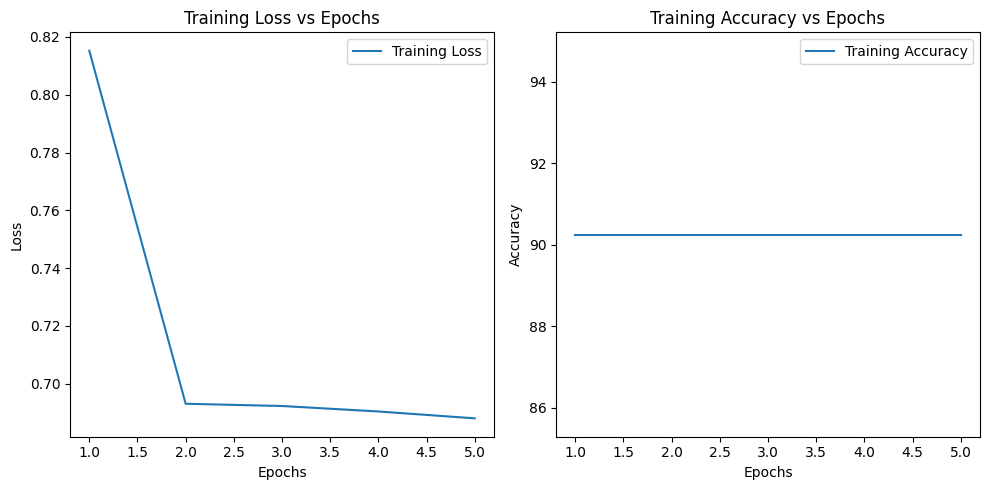

In [234]:
input_dim = 600  
batch_size=32
model = DrugClassifier(600)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
train_model(model, train_loader, criterion, optimizer)


* Imbalanced classes can significantly impact the training of machine learning models, particularly in binary classification tasks. There are several strategies you can employ to handle imbalanced datasets:

Class Weights: As you mentioned, adjusting the class weights can be an effective method. Most loss functions in PyTorch provide a weight parameter that can be used to assign different weights to different classes. For example, nn.BCEWithLogitsLoss() has a pos_weight parameter that can be used to increase the weight of the positive class (1) in your case.
Sampling Techniques: Oversampling the minority class, undersampling the majority class, or using more advanced techniques like SMOTE (Synthetic Minority Over-sampling Technique) can help balance the dataset.
Different Metrics: Accuracy might not be the best metric for assessing performance on imbalanced datasets. Consider using precision, recall, F1-score, or ROC-AUC, which are more informative when dealing with imbalanced classes.



Epoch [1/15], Loss: 0.6604, Accuracy: 90.25%
all the way to epoch 15

...


Epoch [15/15], Loss: 0.0618, Accuracy: 90.25%


`what we encountered is a sample of highly imbalanced dataset, so we take action  by weighting loss function`

tensor(9.2564)
Epoch [1/5], Loss: 1.3032, Accuracy: 59.12%
Epoch [2/5], Loss: 1.2247, Accuracy: 90.25%
Epoch [3/5], Loss: 1.0648, Accuracy: 97.62%
Epoch [4/5], Loss: 0.9305, Accuracy: 100.00%
Epoch [5/5], Loss: 0.9083, Accuracy: 100.00%


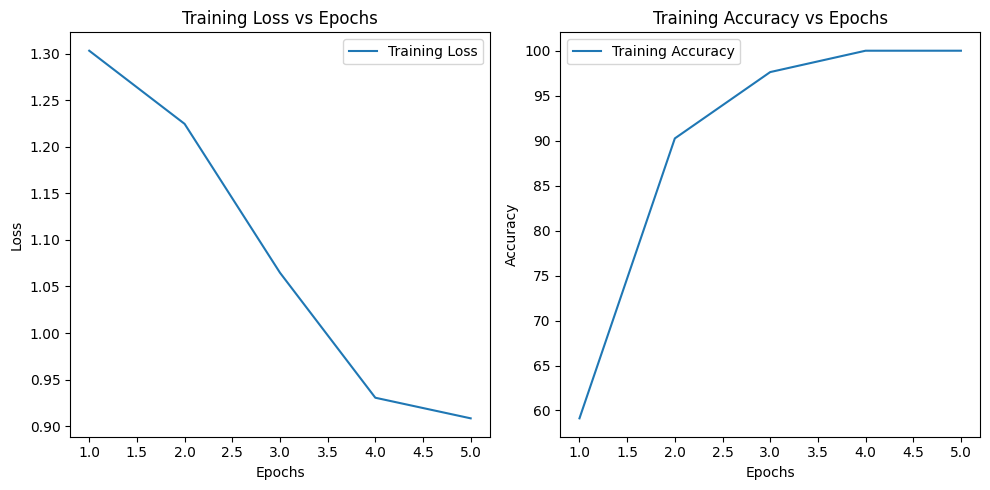

In [259]:
input_dim = 600  
batch_size=32
model = DrugClassifier(600)
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_positive = (train_labels_tensor == 1).sum().item()
num_negative = (train_labels_tensor == 0).sum().item()
pos_weight = torch.tensor(num_negative / num_positive, dtype=torch.float32)
print(pos_weight)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
train_model(model, train_loader, criterion, optimizer)

### 2.6 Testing
After training, test your model on test dataset and compute performance metrics. 

In [255]:
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, labels in test_loader:
            outputs = model(data)
            predicted = (outputs > 0.5)
            predicted= predicted.squeeze()
            correct += np.count_nonzero(predicted == labels)
            total += labels.size(0)
    accuracy = correct / total
    return accuracy


test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)
test_accuracy = evaluate_model(model, test_loader)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


Test Accuracy: 93.71%


Show confusion matrix of your model.

[[301  15]
 [ 10  24]]


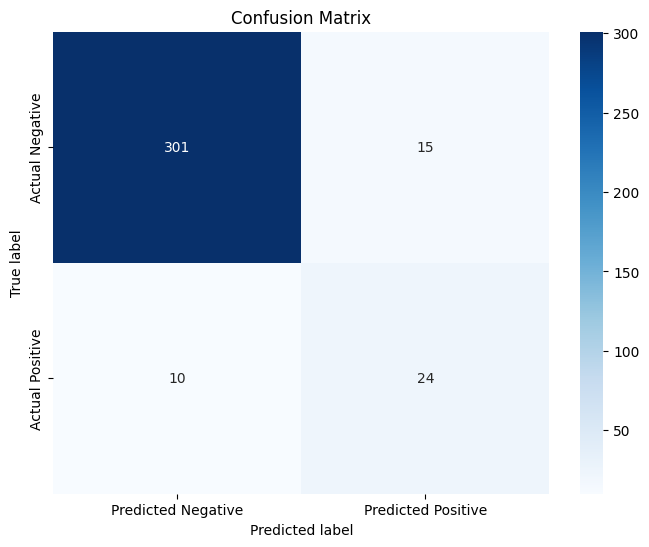

F1 Score: 0.66
Precision: 0.62


In [262]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_score, f1_score
import torch.nn.functional as F

# Assuming you have 'model' and 'test_loader' already defined
def f1_loss(y_true, y_pred):
    tp = (y_true * y_pred).sum().to(torch.float32)
    tn = ((1 - y_true) * (1 - y_pred)).sum().to(torch.float32)
    fp = ((1 - y_true) * y_pred).sum().to(torch.float32)
    fn = (y_true * (1 - y_pred)).sum().to(torch.float32)

    epsilon = 1e-7  # To avoid division by zero
    precision = tp / (tp + fp + epsilon)
    recall = tp / (tp + fn + epsilon)
    f1 = 2 * (precision * recall) / (precision + recall + epsilon)

    return 1 - f1
def evaluate_model(model, test_loader):
    model.eval()
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for data, labels in test_loader:
            outputs = model(data)
            predicted = (outputs > 0.5).float().squeeze()  # Adjust threshold and reshape predictions
            all_predictions.extend(predicted.cpu().numpy())  # Append predictions to a list
            all_labels.extend(labels.cpu().numpy())  # Append true labels to a list

    # Convert lists to numpy arrays
    all_predictions = np.array(all_predictions)
    all_labels = np.array(all_labels)

    # Calculate confusion matrix
    confusion = confusion_matrix(all_labels, all_predictions)
    print(confusion)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion, annot=True, cmap='Blues', fmt='d', 
                xticklabels=['Predicted Negative', 'Predicted Positive'],
                yticklabels=['Actual Negative', 'Actual Positive'])
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title('Confusion Matrix')
    plt.show()
    f1 = f1_score(all_labels, all_predictions)
    precision = precision_score(all_labels, all_predictions)
    print(f"F1 Score: {f1:.2f}")
    print(f"Precision: {precision:.2f}")

# Use the function to calculate and plot the confusion matrix
evaluate_model(model, test_loader)


# now we train the model again with F1 Score criterion

In [263]:
input_dim = 600  
batch_size = 32
model = DrugClassifier(600)
criterion = f1_loss  # Use the custom F1 loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


Epoch [1/5], Loss: 0.8398, Accuracy: 9.75%
Epoch [2/5], Loss: 0.8205, Accuracy: 11.25%
Epoch [3/5], Loss: 0.4556, Accuracy: 95.75%
Epoch [4/5], Loss: 0.0548, Accuracy: 100.00%
Epoch [5/5], Loss: 0.0815, Accuracy: 100.00%


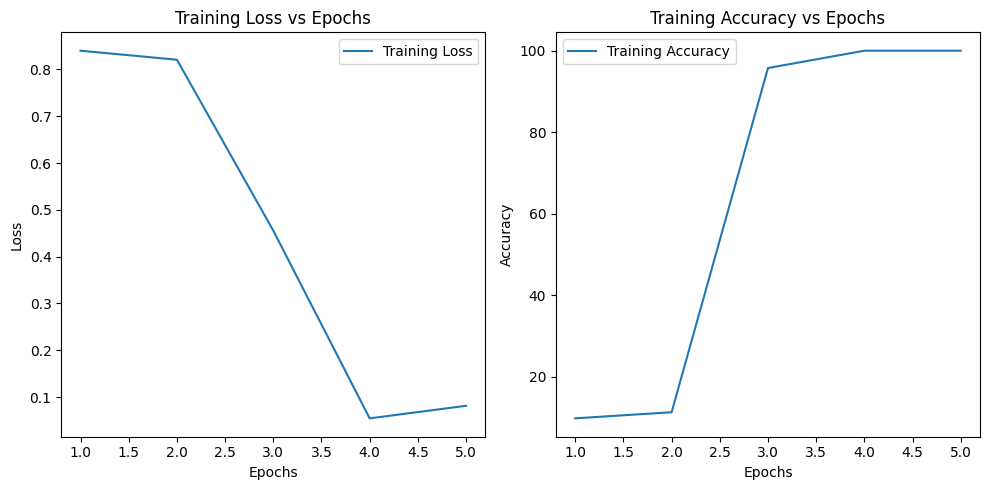

In [264]:
trained_model = train_model(model, train_loader, criterion, optimizer)


[[308   8]
 [ 11  23]]


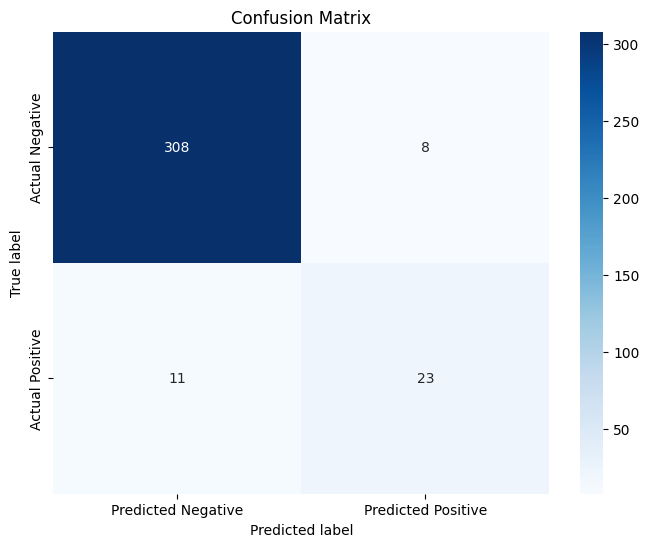

F1 Score: 0.71
Precision: 0.74


In [266]:
evaluate_model(model, test_loader)

## we observe that F1 score increases by changing criterion